In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

In [33]:
data = pd.read_csv("data/reduced_sax_presnap.csv")
data = data.dropna(subset = "playOutcome")

In [34]:
# Step 1: Load and Preprocess Data

data["hour"] = pd.to_datetime(data["time"]).dt.hour
data = data.drop(columns=["position", "time"])

# Encode playOutcome using LabelEncoder
label_encoder = LabelEncoder()
data['playOutcome_encoded'] = label_encoder.fit_transform(data['playOutcome'])

# Drop the original target column and others that are unnecessary
data = data.drop(columns=["playOutcome", "Unnamed: 0", "yardlineSide"])

# Convert all boolean columns to integers
data[data.select_dtypes(include=['bool']).columns] = data.select_dtypes(include=['bool']).astype(int)

# Step 2: Process SAX Data
sax_columns = ['sax_X_std', 'sax_Y_std', 'sax_a', 'sax_s', 'sax_o', 'sax_dir']

# Map Characters to Integers
all_sax_sequences = data[sax_columns].apply(lambda x: ''.join(x), axis=1)
unique_characters = set(''.join(all_sax_sequences))
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_characters)}  # Start indexing from 1

# Create Positional Features Efficiently
max_positions = 15  # Adjust as needed
positional_features = {}

for col in sax_columns:
    for pos in range(max_positions):
        positional_features[f"{col}_pos_{pos + 1}"] = data[col].apply(
            lambda seq: char_to_int[seq[pos]] if pos < len(seq) else 0
        )

# Convert positional features to DataFrame and concatenate
positional_features_df = pd.DataFrame(positional_features)
data = pd.concat([data, positional_features_df], axis=1)

data = data.drop(columns = sax_columns)

# Step 3: Define Features
numeric_features = [
    "hour", "week", "quarter", "down", "yardsToGo", "yardlineNumber",
    "gameClock_min", "gameClock_sec", "preSnapHomeScore", "preSnapVisitorScore",
    "absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "expectedPoints",
    "weight", "age", "time_diff", "distance", "height_inches"
]

# Include boolean columns as categorical
bool_columns = data.select_dtypes(include=['bool']).columns.tolist()

# One-hot encode categorical features

# Combine all features
X = pd.concat([
    data[numeric_features],
    positional_features_df  # Use positional features
], axis=1)

# Step 4: Encode the Target Variable
y = label_encoder.fit_transform(data['playOutcome_encoded'])

majority_class_size = max(Counter(y).values())
scaling_factor = 0.3  # percentage of majority class
sampling_strategy = {
    cls: max(count, int(majority_class_size * scaling_factor))  # Ensure no class is reduced
    for cls, count in Counter(y).items()
}

# Ensure k_neighbors is valid
smallest_class_size = min(Counter(y).values())
k_neighbors = max(1, min(5, smallest_class_size - 1))

# Apply SMOTE with corrected strategy
smote = SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy=sampling_strategy)
X, y = smote.fit_resample(X, y)

# Step 5: Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Step 6: Train a Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Expand until all leaves are pure or min_samples_split is reached
    random_state=1,
    n_jobs=-1          # Use all available CPUs for parallel processing
)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)
y_val = np.array(y_val).astype(int)

rf_model.fit(X_train, y_train)

# Convert target names to strings
target_names = [str(class_name) for class_name in label_encoder.classes_]



# Step 7: Evaluate the Model
y_pred = rf_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.7461300309597523

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       1.00      0.86      0.93        22
           2       0.93      0.70      0.80        20
           3       0.00      0.00      0.00        18
           4       0.71      0.57      0.63        44
           5       0.58      0.50      0.54        14
           6       0.94      0.68      0.79        22
           7       0.78      0.90      0.84        20
           8       0.90      0.69      0.78        13
           9       0.54      0.94      0.69        66
          10       0.83      0.71      0.77        21
          11       0.89      0.80      0.84        20
          12       1.00      1.00      1.00        22

    accuracy                           0.75       323
   macro avg       0.77      0.71      0.73       323
weighted avg       0.74      0.75      0.73       323



/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

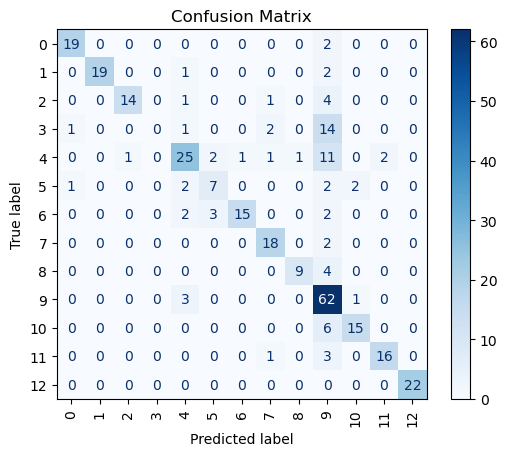

In [35]:
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation = 90)
plt.show()

In [36]:
data["sax_X_std_pos_7"]

1       10
2        5
3        8
6        2
10      15
        ..
3623     8
3624    13
3629     9
3636     8
3639    15
Name: sax_X_std_pos_7, Length: 1097, dtype: int64